In [1]:
!pip  install transformers==4.22.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 23.5 MB/s eta 0:00:00


In [2]:
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
deviceList = tf.test.gpu_device_name()

In [4]:
deviceList

'/device:GPU:0'

In [5]:
df = pd.read_csv("/content/labelled.csv")
df.head()

,Heading,Body,Category,URL
0,free speech not hate speech madras high court ...,madras high court issue significant remark ami...,Judiciary,https://www.indiatoday.in/law/high-courts/stor...
1,comment take context say us cop mock indian st...,seattle police officer guild friday come defen...,Crime,https://www.indiatoday.in/world/story/indian-s...
2,first meeting one nation one election committe...,first official meeting one nation one election...,Politics,https://www.indiatoday.in/india/story/one-nati...
3,us airlines flight depressurize midair plummet...,united airlines jet head rome turn around less...,Crime,https://www.indiatoday.in/world/story/us-fligh...
4,terrorist kill security force foil infiltratio...,three terrorist kill infiltration bid foil sec...,Crime,https://www.indiatoday.in/india/story/one-terr...


In [6]:
df.shape

(11583, 4)

In [7]:
df['count'] = df['Body'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

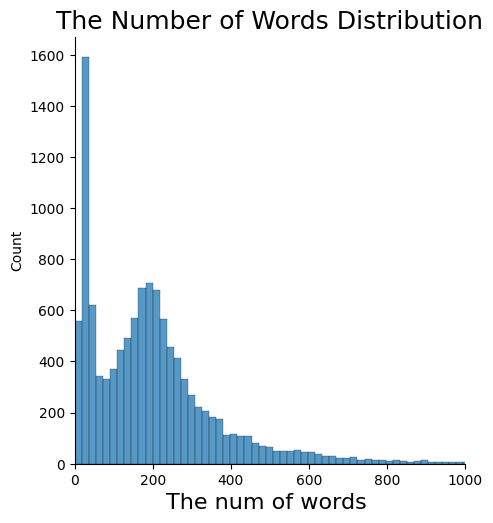

In [8]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [9]:
category_count = df['Category'].value_counts()

categories = category_count.index

categories


Index(['Entertainment', 'Business', 'Politics', 'Judiciary', 'Crime',
       'Culture', 'Sports', 'Science', 'International', 'Technology'],
      dtype='object')

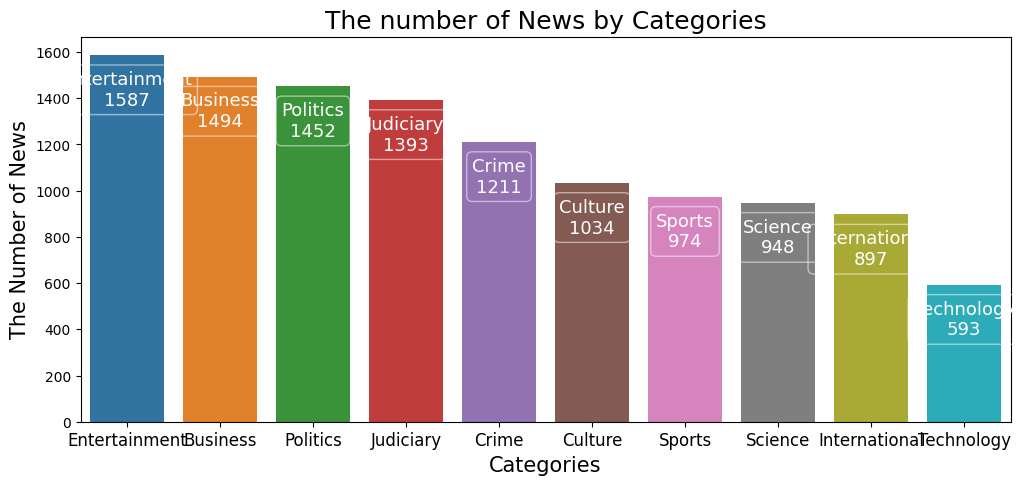

In [10]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [11]:
categories = {
    "Entertainment" :   0,
"Business"  :       1,
"Politics"   :      2,
"Judiciary"   :     3,
"Crime"     :       4,
"Culture"    :      5,
"Sports"      :      6,
"Science"      :     7,
"International" :    8,
"Technology"     :   9
}

print(categories)


{'Entertainment': 0, 'Business': 1, 'Politics': 2, 'Judiciary': 3, 'Crime': 4, 'Culture': 5, 'Sports': 6, 'Science': 7, 'International': 8, 'Technology': 9}


In [12]:
def map_to_encoding(text):
    return categories.get(text, -1)  # Return -1 if not found

# Create the 'category_encoding' column
df['category_encoding'] = df['Category'].apply(map_to_encoding)

In [13]:
df.head()

,Heading,Body,Category,URL,count,category_encoding
0,free speech not hate speech madras high court ...,madras high court issue significant remark ami...,Judiciary,https://www.indiatoday.in/law/high-courts/stor...,174,3
1,comment take context say us cop mock indian st...,seattle police officer guild friday come defen...,Crime,https://www.indiatoday.in/world/story/indian-s...,699,4
2,first meeting one nation one election committe...,first official meeting one nation one election...,Politics,https://www.indiatoday.in/india/story/one-nati...,168,2
3,us airlines flight depressurize midair plummet...,united airlines jet head rome turn around less...,Crime,https://www.indiatoday.in/world/story/us-fligh...,95,4
4,terrorist kill security force foil infiltratio...,three terrorist kill infiltration bid foil sec...,Crime,https://www.indiatoday.in/india/story/one-terr...,106,4


In [14]:
newsArticlesBody = df['Body'].to_list()

categoryLabels = df['category_encoding'].to_list()

In [15]:
# Split the data into training, validation, and test sets (80% train, 10% val, 10% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    newsArticlesBody, categoryLabels, test_size=0.2, random_state=42, stratify = categoryLabels)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42, stratify = test_labels)

# Display the size of each dataset
print("Train set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))

# Verify the splitting and shuffle
print("Sample train text:", train_texts[0])
print("Sample train label:", train_labels[0])


Train set size: 9266
Validation set size: 1158
Test set size: 1159
Sample train text: rashmika mandanna allu arjun highly anticipate film pushpa rule leave fan eager excite film release maker leave part cliffhanger people high expectation sequel among cast member malayalam superstar fahadh faasil cameo appearance ips bhanwar singh shekhawat receive major attention intensity menacing performance although make brief appearance prequel fahadh play significant role alongside allu arjun upcoming film meanwhile late report state actor charge staggering rs crore role villain sequel leave fan astonishedfahadh faasil substantial fee role make one highestpaid villain south indian film industry accord report deccan chronicle consider film grand scale budget producer willing meet demand fahadh faasil fee rs crore role pushpa portion demand pushpa despite low compensation menacing performance iconic dialogue make last impacta source close production say talented actor kind role effortlessly ask ess

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


In [18]:
from transformers import TFDistilBertModel, DistilBertTokenizer

In [23]:
# Define the model architecture using Keras Functional API
def build_model(max_length, num_labels):
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    # Load the DistilBERT model
    distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    # Freeze the DistilBERT layers
    distilbert_model.trainable = False

    # Get the DistilBERT output
    distilbert_output = distilbert_model([input_ids, attention_mask])[0]

    # Add a dense layer for classification
    output = Dense(num_labels, activation='softmax')(distilbert_output[:, 0, :])  # We use only the [CLS] token

    # Define the model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

In [24]:
max_length = 512  # Maximum sequence length
num_labels = 10  # Number of labels

# Build the model
model = build_model(max_length, num_labels)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 512, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [25]:
# Convert BatchEncoding objects to NumPy arrays
train_input_ids = np.array(train_encodings["input_ids"])
train_attention_mask = np.array(train_encodings["attention_mask"])
train_labels = np.array(train_labels)

val_input_ids = np.array(train_encodings["input_ids"])
val_attention_mask = np.array(train_encodings["attention_mask"])
val_labels = np.array(train_labels)
valDataset = ([val_input_ids, val_attention_mask], val_labels)

In [26]:

model.fit(
    x=[train_input_ids, train_attention_mask],
    y=train_labels,
    validation_data=valDataset,
    epochs=10,
    batch_size=16,
)

# Print the training progress
print("Training completed.")


Epoch 1/10
580/580 [==============================] - 411s 698ms/step - loss: 1.0924 - accuracy: 0.6500 - val_loss: 0.8430 - val_accuracy: 0.7301
Epoch 2/10
580/580 [==============================] - 402s 694ms/step - loss: 0.9715 - accuracy: 0.6995 - val_loss: 0.8140 - val_accuracy: 0.7479
Epoch 3/10
580/580 [==============================] - 402s 694ms/step - loss: 0.9363 - accuracy: 0.7140 - val_loss: 0.9629 - val_accuracy: 0.7077
Epoch 4/10
580/580 [==============================] - 402s 694ms/step - loss: 0.9261 - accuracy: 0.7184 - val_loss: 0.7933 - val_accuracy: 0.7464
Epoch 5/10
580/580 [==============================] - 402s 694ms/step - loss: 0.9444 - accuracy: 0.7171 - val_loss: 0.7412 - val_accuracy: 0.7627
Epoch 6/10
580/580 [==============================] - 402s 694ms/step - loss: 0.9092 - accuracy: 0.7204 - val_loss: 0.9560 - val_accuracy: 0.6881
Epoch 7/10
580/580 [==============================] - 402s 693ms/step - loss: 0.8968 - accuracy: 0.7158 - val_loss: 0.7212 -

In [27]:
model.save("distilbert_model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [28]:
model.evaluate((val_input_ids, val_attention_mask), val_labels)

290/290 [==============================] - 181s 623ms/step - loss: 0.7719 - accuracy: 0.7543


[0.7719079852104187, 0.7542629241943359]

In [29]:
test_encodings = tokenizer(test_texts, truncation = True, padding = True  )

test_input_ids = np.array(test_encodings["input_ids"])
test_attention_mask = np.array(test_encodings["attention_mask"])

In [30]:
y_pred = model.predict([test_input_ids, test_attention_mask])
y_pred

37/37 [==============================] - 24s 608ms/step


array([[2.0829034e-06, 2.3786721e-03, 3.7582874e-01, ..., 8.0072600e-04,
        4.5939180e-01, 2.9411990e-06],
       [4.8598667e-05, 1.6409015e-04, 1.4571157e-04, ..., 9.4836032e-05,
        2.4267675e-04, 3.7134264e-08],
       [1.2095400e-05, 9.9741971e-01, 5.6734916e-05, ..., 2.9068076e-04,
        9.0385540e-05, 9.0996315e-07],
       ...,
       [1.5054489e-06, 7.5442536e-04, 1.7141207e-03, ..., 1.0732346e-04,
        9.9618441e-01, 5.2502852e-08],
       [1.2633367e-02, 1.8998709e-01, 6.2949006e-03, ..., 4.8188688e-03,
        2.1588394e-02, 7.1208756e-03],
       [1.5029192e-06, 1.0818379e-02, 7.6052409e-01, ..., 8.5057318e-04,
        8.8119612e-04, 1.9310053e-06]], dtype=float32)

In [31]:
y_pred[0].argmax()

8

In [32]:
y_pred_new = []
for i in range(len(y_pred)):
   y_pred_new.append(y_pred[i].argmax())

In [33]:
y_test = test_labels
y_test

[2,
 6,
 1,
 6,
 1,
 7,
 0,
 4,
 3,
 2,
 5,
 8,
 4,
 1,
 0,
 5,
 5,
 4,
 0,
 3,
 3,
 5,
 8,
 1,
 9,
 7,
 1,
 0,
 1,
 2,
 0,
 0,
 6,
 0,
 6,
 0,
 1,
 0,
 1,
 0,
 4,
 3,
 5,
 5,
 1,
 8,
 0,
 8,
 3,
 0,
 1,
 9,
 1,
 1,
 1,
 7,
 3,
 8,
 5,
 3,
 1,
 0,
 6,
 7,
 0,
 6,
 2,
 8,
 4,
 2,
 7,
 0,
 3,
 3,
 6,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 9,
 6,
 9,
 5,
 4,
 7,
 4,
 6,
 1,
 0,
 3,
 2,
 2,
 5,
 5,
 8,
 8,
 0,
 4,
 1,
 2,
 6,
 7,
 4,
 0,
 9,
 2,
 2,
 5,
 5,
 2,
 9,
 1,
 2,
 2,
 1,
 6,
 8,
 1,
 5,
 0,
 9,
 3,
 4,
 5,
 5,
 3,
 0,
 5,
 3,
 0,
 4,
 9,
 2,
 6,
 1,
 7,
 8,
 4,
 4,
 8,
 2,
 2,
 8,
 3,
 0,
 6,
 5,
 4,
 1,
 7,
 5,
 3,
 1,
 3,
 2,
 0,
 0,
 5,
 2,
 6,
 6,
 4,
 6,
 1,
 6,
 0,
 7,
 4,
 9,
 0,
 2,
 5,
 4,
 6,
 3,
 9,
 6,
 2,
 8,
 3,
 2,
 6,
 5,
 3,
 2,
 6,
 7,
 4,
 6,
 9,
 6,
 3,
 5,
 1,
 2,
 2,
 2,
 0,
 5,
 3,
 0,
 3,
 3,
 7,
 2,
 9,
 1,
 1,
 9,
 8,
 5,
 4,
 3,
 3,
 8,
 0,
 3,
 8,
 2,
 3,
 0,
 0,
 8,
 3,
 1,
 6,
 2,
 8,
 1,
 1,
 0,
 5,
 4,
 1,
 2,
 3,
 8,
 1,
 1,
 0,
 4,
 7,
 1,
 3,
 4,
 1,
 0,


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_test and y_pred are available

# Accuracy
accuracy = accuracy_score(y_test, y_pred_new)

# Precision
precision = precision_score(y_test, y_pred_new, average='weighted')  # Use 'weighted' for multiclass

# Recall
recall = recall_score(y_test, y_pred_new, average='weighted')  # Use 'weighted' for multiclass

# F1-score
f1 = f1_score(y_test, y_pred_new, average='weighted')  # Use 'weighted' for multiclass

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_new)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7187230371009491
Precision: 0.7639201994667857
Recall: 0.7187230371009491
F1-score: 0.7296743859419802
Confusion Matrix:
[[124   3   1  14   2  10   2   2   0   1]
 [  1 115   3  19   0   4   0   2   6   0]
 [  0   3  86  49   0   2   1   0   4   0]
 [  0  10   9 107   3   7   0   2   2   0]
 [  0   3   0  23  81   3   0   2   9   0]
 [  3   8   2  20   3  55   1  11   1   0]
 [  0   3   2   1   1   4  82   0   4   0]
 [  0   8   0   8   1   7   0  68   1   2]
 [  0   3   5   9   2   1   0   0  69   0]
 [  0   7   0   3   0   2   0   1   0  46]]


In [ ]:
# model.save('bertModel2')

# # Or save only the model architecture to a JSON file
# model_json = model.to_json()
# with open('bertModel2_architecture.json', 'w') as json_file:
#     json_file.write(model_json)

# # Save the model weights to an HDF5 file
# model.save_weights('bertModel2_weights.h5')

In [ ]:
def getEncoding(text):
  test_encodings = tokenizer(text, truncation = True, padding = True  , return_tensors='tf')

  test_input_ids = np.array(test_encodings["input_ids"])
  test_attention_mask = np.array(test_encodings["attention_mask"])
  return [test_input_ids, test_attention_mask]

In [ ]:
enc = getEncoding("bid republican presidential nomination vivek ramaswamy age present straightshoote truthteller formidable debater however former employee ventures roivant science strive asset management describe neurotic mercurial paranoid leader private reported business insiderdure recent republican primary debate august vivek ramaswamys confident charismatic bold demeanor endear voter showcase memeworthy entrepreneur thrive conflict not shy away fight however seven individual work closely ramaswamy claim neurotic mercurial paranoid leader accord one former colleague ramaswamy believe people exist serve suggest sense entitlement aspect management style peculiar example would order taco bell office birthday also know demand whiteglove service staff laundry list unusual rule procedure meet every need one notable eccentricity fixation temperature control insist office thermostat roivant strive set degree fahrenheit low make workspace uncomfortably cold coworker reportedly resort use space heater wear fleece sweater combat chill travel ramaswamys demand extend book multiple backup flight hotel room reflect obsessive need travel run smoothly even order takeout lunch assistant plate food serve napkin another quirk insistence cottage cheese serve desk every morning notably ramaswamy former army ranger personal security guard even enter presidential race security guard regularly sweep strive office security threat ramaswamys colleague business partner acknowledge intensity intelligence energy salesmanship work hedge fund qvt graduate harvard simultaneously attend yale age found roivant pharmaceutical company despite limited experience drug development employee roivant describe environment akin fastmoving tech startup traditional pharmaceutical company ramaswamys fundraising prowess attract investor softbank vision fund founder fund vike global investor ramaswamys business venture include roivant bring several drug development market achieve significant success however even project fail often benefit personally praise ramaswamy visionary leader view hype man use charisma eloquence boost value company two former employee file lawsuit accuse violate security law use unapproved marketing material pitch investor strive etfs legally permissible ramaswamy continue presidential campaign contrast portrait paint public persona former employee would light complexity leadership style character")

In [ ]:
model.predict(enc)